# Practical Time Series Lecture 2 - Stationarity and Autocorrelation

* Understanding Stationarity
* Methods to Achieve Stationarity
* Autocorrelation Functions (ACF & PACF)

## Imports

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns

import statsmodels as ss
from statsmodels.graphics.tsaplots import plot_acf

# suppress warnings
import warnings
warnings.filterwarnings('ignore') 

## Load Data Sets 

In [110]:
from statsmodels.datasets import co2, get_rdataset

# Mauna Loa Weekly Atmospheric CO2 Data
co2_df = co2.load_pandas().data
# set frequency of time series
co2_df = co2_df.interpolate(method='polynomial', order=3) # Interpolate the missing values

#Monthly Airline Passenger Numbers 1949-1960, in thousands
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

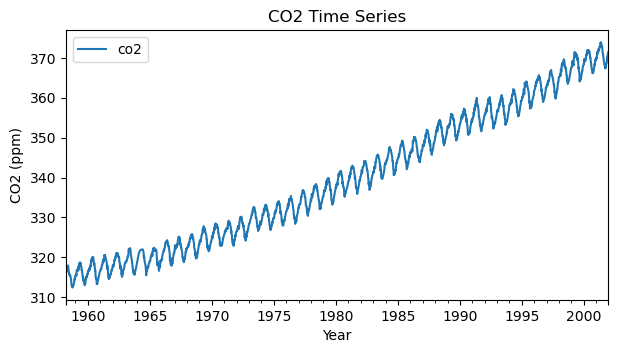

Frequency-  W-SAT


In [111]:
co2_df.plot(figsize=(7, 3.5))
plt.title('CO2 Time Series')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.show()

# get the frequency of the co2 time series
print('Frequency- ',co2_df.index.inferred_freq) 

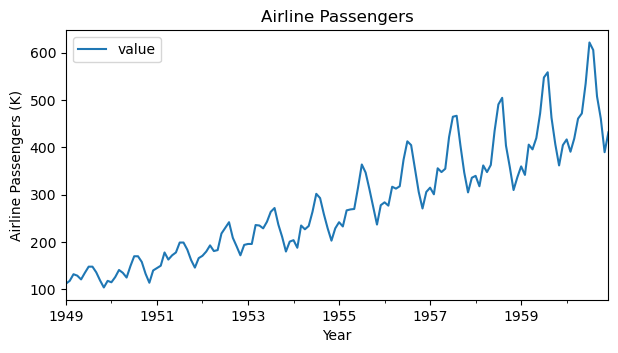

Frequency-  ME


In [112]:
airp_df.plot(figsize=(7, 3.5))
plt.title('Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Airline Passengers (K)')
plt.show()
# get the frequency of the airp time series
print('Frequency- ',airp_df.index.inferred_freq)

Frequency-  None
New Frequency-  D


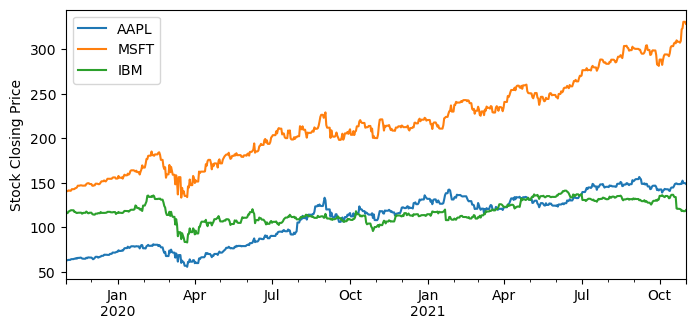

In [85]:
# load the file of stocks closing_price.csv to df from the folder 'Data_sets' 
closing_price = pd.read_csv('../Data_sets/closing_price.csv', index_col='Date', parse_dates=True)

# get the frequency of the closing_price time series
print('Frequency- ',closing_price.index.inferred_freq)

# set the frequency of the closing_price time series (for statmodels functions)
new_index = pd.date_range(start=closing_price.index.min(), end=closing_price.index.max(), freq='D')
closing_price = closing_price.reindex(new_index).fillna(method='ffill') # match weekend and holiday dates for stock market with the previous day's closing price
print('New Frequency- ',closing_price.index.inferred_freq)
# plot the closing_price time series
closing_price.plot(figsize=(8, 3.5))
plt.ylabel('Stock Closing Price')
plt.show()


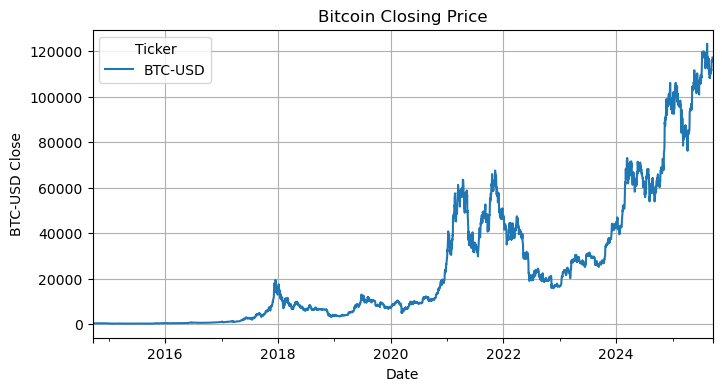

In [91]:
# Download Bitcoin data from Yahoo Finance and handle possible download errors
import yfinance as yf


btc_data = yf.download('BTC-USD', start='2010-01-01', end='2025-10-22', progress=False)
if btc_data.empty or 'Close' not in btc_data.columns:
    raise ValueError("No data returned or 'Close' column missing.")
btc_close = btc_data['Close']


btc_close.plot(figsize=(8, 4))
plt.title('Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('BTC-USD Close')
plt.grid(True)
plt.show()


## Understansing Stationarity

### Simulating basic stationary time series processes


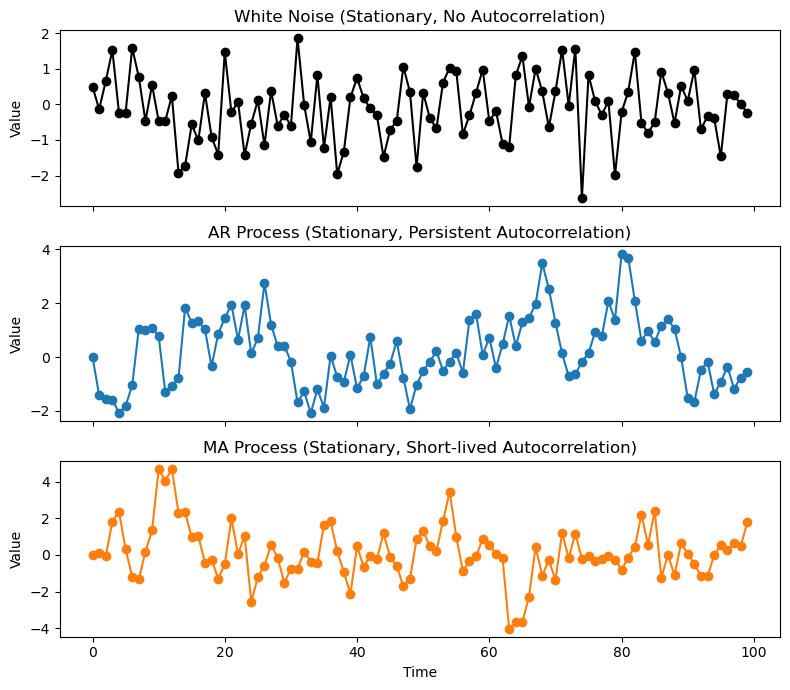

In [23]:
# --- Reproducibility & settings ---
np.random.seed(42)
n = 100
phi = 0.8    # AR(1) coefficient
theta = 0.8  # MA(1) coefficient

# --- Simulate processes ---
# White noise
wn = np.random.normal(0, 1, n)

# AR(1): X_t = phi * X_{t-1} + e_t
ar = np.zeros(n)
for t in range(1, n):
    ar[t] = phi * ar[t-1] + np.random.normal(0, 1) 

# MA(1): X_t = e_t + theta * e_{t-1}
eps = np.random.normal(0, 1, n)
ma = np.zeros(n)
for t in range(1, n):
    ma[t] = eps[t] + theta * eps[t-1] + theta * eps[t-2]

# --- Plot time series ---
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
axes[0].plot(wn, marker='o', linestyle='-', color='black')
axes[0].set_title("White Noise (Stationary, No Autocorrelation)")
axes[0].set_ylabel("Value")

axes[1].plot(ar, marker='o', linestyle='-', color='tab:blue')
axes[1].set_title("AR Process (Stationary, Persistent Autocorrelation)")
axes[1].set_ylabel("Value")

axes[2].plot(ma, marker='o', linestyle='-', color='tab:orange')
axes[2].set_title("MA Process (Stationary, Short-lived Autocorrelation)")
axes[2].set_ylabel("Value")
axes[2].set_xlabel("Time")

plt.tight_layout()
plt.show()

# # --- Plot ACFs to highlight differences ---
# fig_acf, axes_acf = plt.subplots(3, 1, figsize=(12, 9))
# plot_acf(wn, lags=20, ax=axes_acf[0], zero=False)
# axes_acf[0].set_title("ACF: White Noise (no spikes beyond lag 0)")

# plot_acf(ar1, lags=20, ax=axes_acf[1], zero=False)
# axes_acf[1].set_title("ACF: AR(1) (gradual/exponential decay)")

# plot_acf(ma1, lags=20, ax=axes_acf[2], zero=False)
# axes_acf[2].set_title("ACF: MA(1) (cutoff after lag 1)")

# plt.tight_layout()
# plt.show()


### Testing for Stationarity

In [ ]:
# create pure random stationary data with mean 0 and standard deviation 1
stationary = np.random.normal(0, 1, 1000)
stationary = pd.Series(stationary, index=pd.date_range('2020-01-01', periods=1000, freq='D'))

#### Summary of distribution Statistics
Splits the data into specified number of time frames, calculates mean and variance for each frame,
creates a DataFrame with these statistics, plots the statistics, and prints the DataFrame.



In [17]:

def analyze_time_frames(data, num_time_frames=10):
    """
    Parameters:
    - data: Pandas Series or numpy array containing the time series data
    - num_time_frames: Integer specifying how many time frames to split the data into
    Returns:
    - stats_df: DataFrame containing the mean and variance for each time frame.
    """
    # Split data into specified number of time frames
    time_frames = np.array_split(data, indices_or_sections=num_time_frames)
    # Calculate mean and variance for each time frame individually
    means = [np.mean(frame) for frame in time_frames]
    variances = [np.var(frame) for frame in time_frames]
    # Create a DataFrame with the calculated statistics
    stats_df = pd.DataFrame({'mean': means, 'var': variances})
    # Plotting the statistics
    stats_df.plot(subplots=True, sharex=True, title='time series stats')
    plt.xlabel('Time Frame')
    plt.show()
    # Print the DataFrame
    print(stats_df)

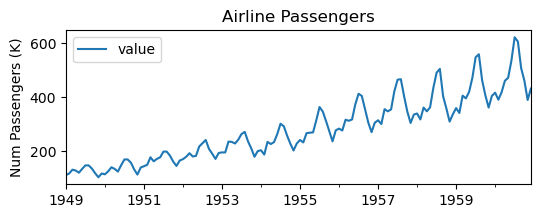

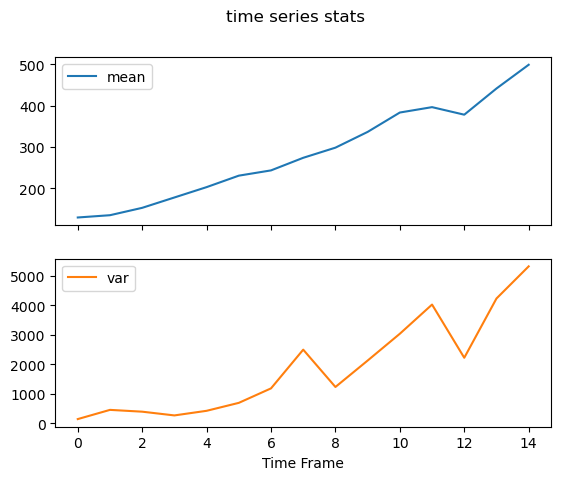

          mean          var
0   129.800000   138.360000
1   135.300000   451.210000
2   153.100000   389.890000
3   178.100000   262.890000
4   203.100000   419.490000
5   230.800000   689.560000
6   243.500000  1181.850000
7   273.900000  2497.090000
8   298.400000  1229.040000
9   336.444444  2126.691358
10  383.222222  3037.728395
11  396.222222  4028.839506
12  378.000000  2221.555556
13  441.222222  4234.395062
14  498.555556  5326.691358


In [36]:
# plot airp_df 
airp_df.plot(figsize=(6, 2))
plt.title('Airline Passengers')
plt.ylabel('Num Passengers (K)')
plt.show()

analyze_time_frames(airp_df['value'], num_time_frames=15)



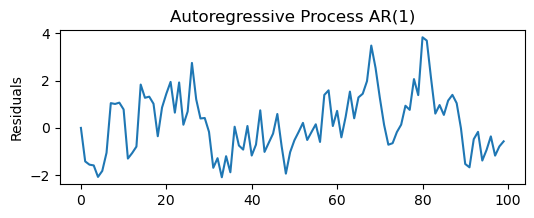

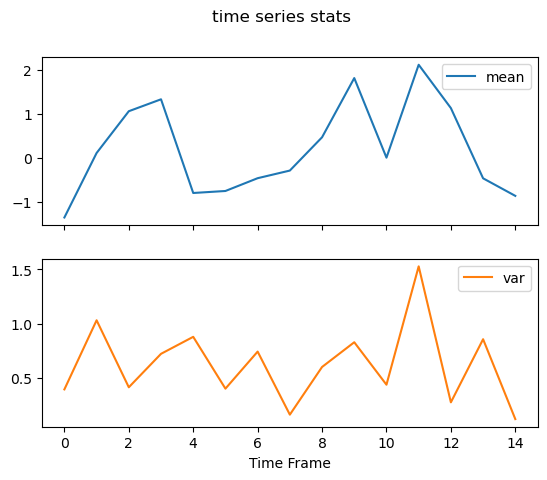

        mean       var
0  -1.355893  0.392923
1   0.107820  1.030572
2   1.056356  0.412391
3   1.326769  0.721058
4  -0.799939  0.877810
5  -0.754387  0.399792
6  -0.464153  0.741597
7  -0.290884  0.159745
8   0.464728  0.599657
9   1.808663  0.827868
10  0.001864  0.436129
11  2.110791  1.528056
12  1.127046  0.273496
13 -0.466840  0.855865
14 -0.865110  0.118885


In [35]:
# plot airp residuals
plt.figure(figsize=(6, 2))
plt.plot(ar)
plt.title('Autoregressive Process AR(1)')
plt.ylabel('Residuals')
plt.show()

analyze_time_frames(ar, num_time_frames=15)

#### Statistical tests: 


#### Augmented Dickey Fuller (ADF) Test
* **Null hypothesis:** the series is non-stationary (has unit root)
* **Reject hypothesis:** the series is stationary.

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
* **Null hypothesis:** the series is stationary (no unit root)
* **Reject hypothesis:** the series is non-stationary.

set a significance level or threshold (normaly p_value=0.05) to reject the null hypothesis. 

In [38]:
from statsmodels.tsa.stattools import adfuller, kpss

In [73]:
def test_stationarity(ts):
    result_ADF = adfuller(ts) 
    p_value_ADF = result_ADF[1]
    print(f'ADF Statistic: {result_ADF[0]:.3f}')
    print(f'ADF p-value: {p_value_ADF:.3f}')
    if p_value_ADF < 0.05:
        print('p-value < 0.05: the series is stationary')
    else:
        print('p-value > 0.05: the series is non-stationary')
    print('--------------------------------')
    
    result_KPSS = kpss(ts)
    p_value_KPSS = result_KPSS[1]
    print(f'KPSS Statistic: {result_KPSS[0]:.3f}')
    print(f'KPSS p-value: {p_value_KPSS:.3f}')
    if p_value_KPSS > 0.05:
        print('p-value > 0.05: the series is stationary')
    else:
        print('p-value < 0.05: the series is non-stationary')



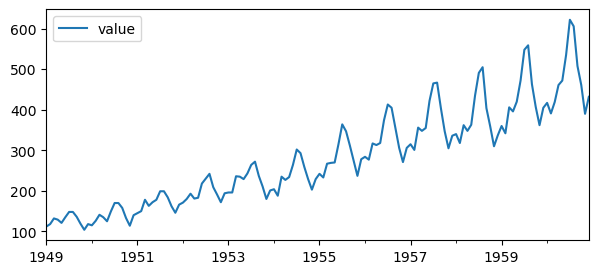

ADF Statistic: 0.815
ADF p-value: 0.992
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 1.651
KPSS p-value: 0.010
p-value < 0.05: the series is non-stationary


In [82]:
airp_df.plot(figsize=(7, 3))
plt.show()

test_stationarity(airp_df)


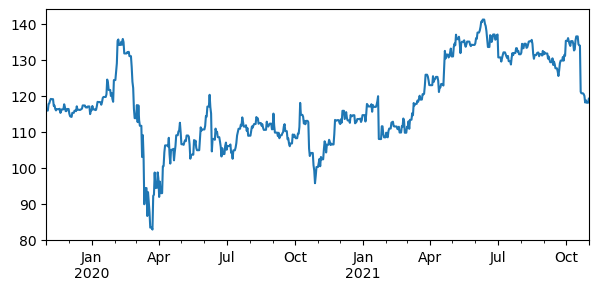

ADF Statistic: -2.392
ADF p-value: 0.144
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 1.914
KPSS p-value: 0.010
p-value < 0.05: the series is non-stationary


In [83]:
closing_price['IBM'].plot(figsize=(7, 3))
plt.show()

test_stationarity(closing_price['IBM'])

ADF Statistic: -4.173
ADF p-value: 0.001
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.181
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


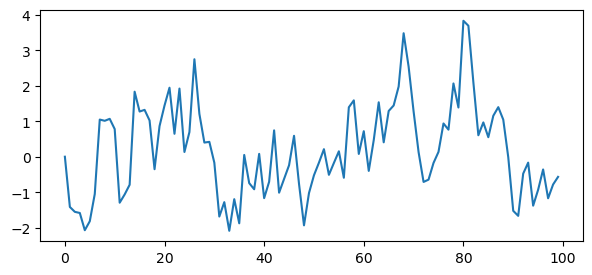

In [84]:
plt.figure(figsize=(7, 3))
plt.plot(ar)

test_stationarity(ar)

### Stationary Transformations

#### Log Transform
- Apply natural logarithm in base e
- **Log Transform** vs **Log Scale** Visualization

##### Apply Log transform to Bitcoin data 

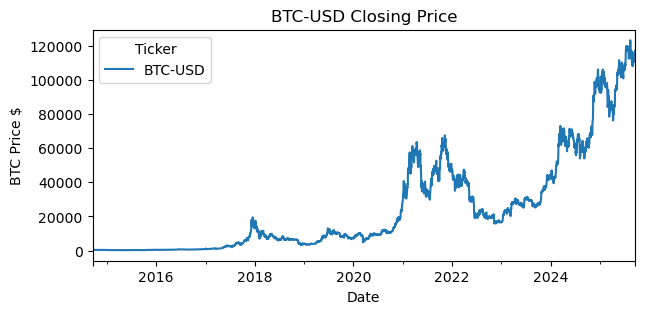

In [92]:
# plot the closing price
btc_close.plot(title='BTC-USD Closing Price', figsize=(7, 3)) 
plt.ylabel('BTC Price $')
plt.show()

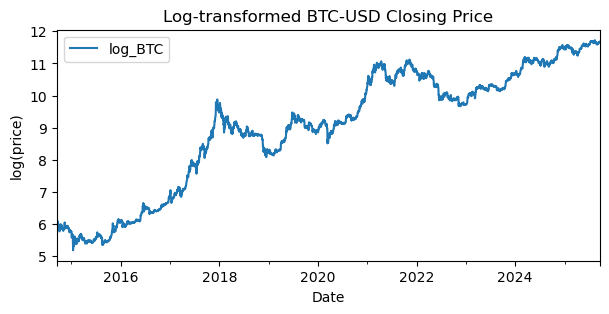

,log_BTC
Date,
2025-09-13,11.660919
2025-09-14,11.656226
2025-09-15,11.656548
2025-09-16,11.668588
2025-09-17,11.672062


In [107]:
 # Apply the log transformation
btc_log = np.log(btc_close) # log transformation base e
btc_log.columns = ['log_BTC']

btc_log.plot(title='Log-transformed BTC-USD Closing Price', figsize=(7, 3))
plt.ylabel('log(price)')
plt.show()

btc_log.tail()

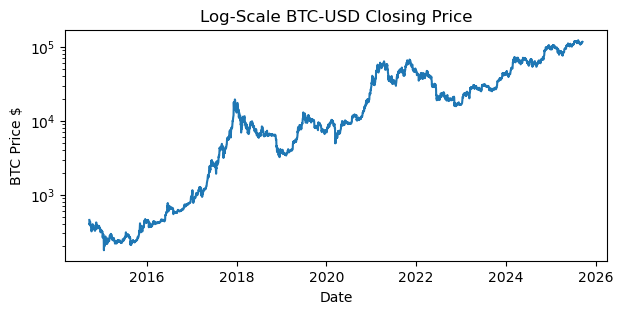

Ticker,BTC-USD
Date,
2025-09-13,115950.507812
2025-09-14,115407.656250
2025-09-15,115444.875000
2025-09-16,116843.187500
2025-09-17,117249.843750


In [108]:
## Show the btc_close but with log scale axis
plt.figure(figsize=(7, 3))
plt.plot(btc_close)
plt.yscale('log')
# give title and axis labels
plt.title('Log-Scale BTC-USD Closing Price')
plt.xlabel('Date')
plt.ylabel('BTC Price $')
plt.show()

btc_close.tail()


##### Reverse Log Transform

<Figure size 700x300 with 0 Axes>

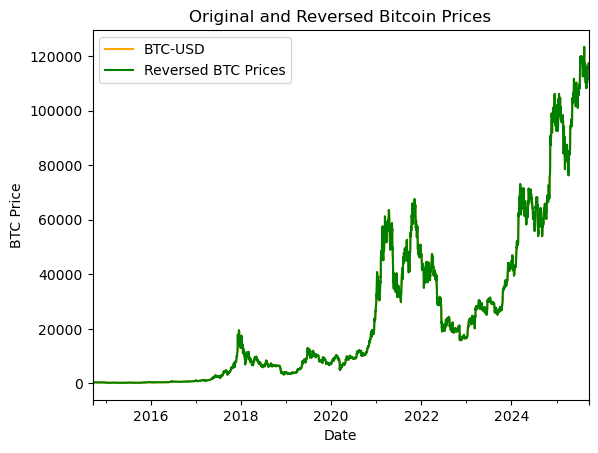

In [145]:
# reverse the log transformation
btc_reversed = np.exp(btc_log['log_BTC'])
# put back in df
btc_reversed = pd.Series(btc_reversed, index=btc_close.index)

# plot the original data and the reversed data
plt.figure(figsize=(7, 3))
btc_close.plot(label='Original BTC Prices', color='orange')
btc_reversed.plot(label='Reversed BTC Prices', color='green')
plt.title('Original and Reversed Bitcoin Prices')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

### Differencing

,value
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


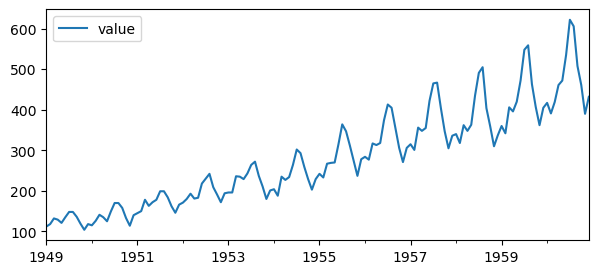

In [117]:
airp_df.plot(figsize=(7, 3))
airp_df.head()

##### First Order Differencing

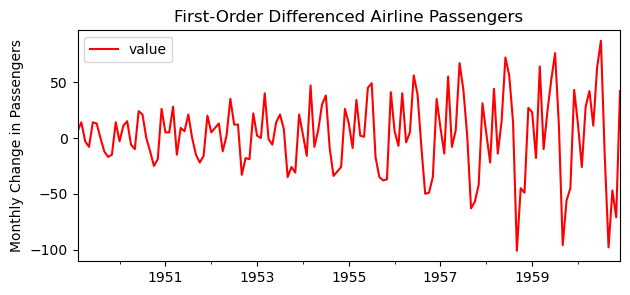

ADF Statistic: -2.829
ADF p-value: 0.054
p-value > 0.05: the series is non-stationary
--------------------------------
KPSS Statistic: 0.024
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [143]:
# Apply first-order differencing
airp_diff = airp_df.diff().dropna()

# plot the differenced series
airp_diff.plot(figsize=(7, 3), color='red')
# give title and axis labels
plt.title('First-Order Differenced Airline Passengers')
plt.ylabel('Monthly Change in Passengers')
plt.show()

test_stationarity(airp_diff)

##### Seasonal Differencing

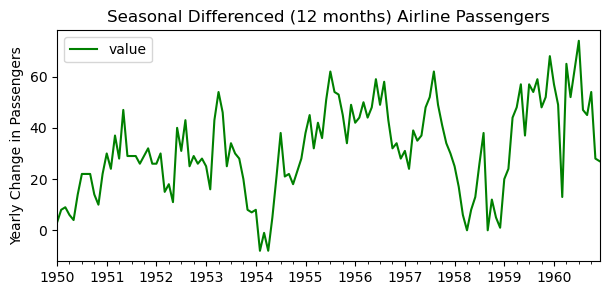

ADF Statistic: -3.383
ADF p-value: 0.012
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.534
KPSS p-value: 0.034
p-value < 0.05: the series is non-stationary


In [142]:
# Apply seasonal differencing to the air_p data
airp_seasonal_diff = airp_df.diff(12).dropna()

# Plot seasonal differenced data
airp_seasonal_diff.plot(figsize=(7, 3), color='green')
plt.title('Seasonal Differenced (12 months) Airline Passengers')
plt.ylabel('Yearly Change in Passengers')
plt.legend()
plt.show()

test_stationarity(airp_seasonal_diff)

##### Apply 1st order & Seasonal

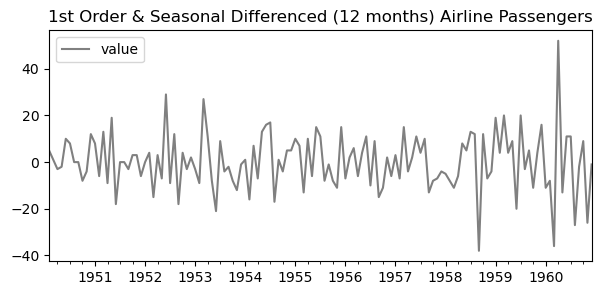

ADF Statistic: -15.596
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.047
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [130]:
# Apply 1st order & Seasonal differencing to the air_p data
airp_diff_seasonal_diff = airp_df.diff().diff(12).dropna()

# Plot seasonal differenced data
airp_diff_seasonal_diff.plot(figsize=(7, 3), color='gray')
plt.title('1st Order & Seasonal Differenced (12 months) Airline Passengers')
plt.legend()
plt.show()

test_stationarity(airp_diff_seasonal_diff)

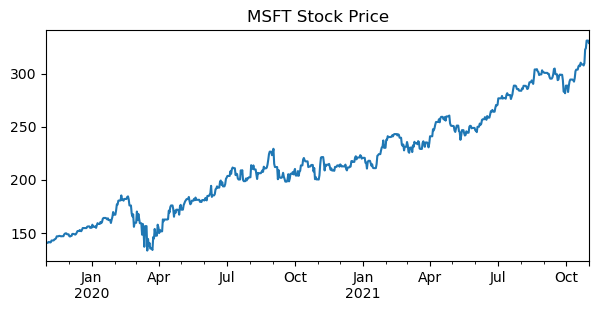

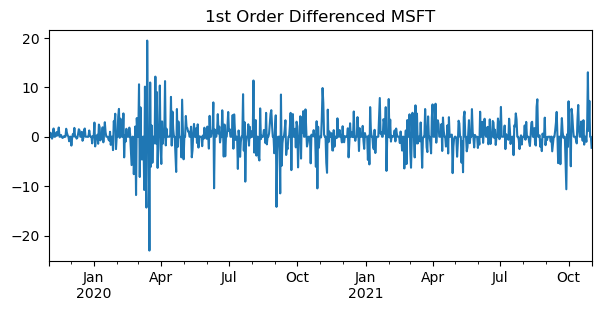

ADF Statistic: -6.183
ADF p-value: 0.000
p-value < 0.05: the series is stationary
--------------------------------
KPSS Statistic: 0.093
KPSS p-value: 0.100
p-value > 0.05: the series is stationary


In [ ]:
closing_price['MSFT'].plot(figsize=(7, 3), title='MSFT Stock Price')
plt.show()

# Apply 1st order differencing to this column and save to new df
msft_diff = closing_price['MSFT'].diff().dropna()

# Plot the differenced data
msft_diff.plot(figsize=(7, 3), title='1st Order Differenced MSFT')
plt.show()

test_stationarity(msft_diff)


##### Reverse Differencing

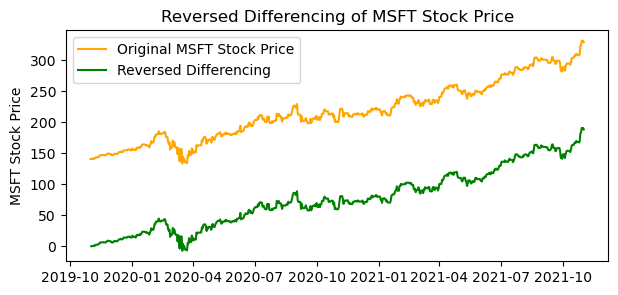

In [147]:
## Reverse the differencing from MSFT
msft_diff_reversed = msft_diff.cumsum()

#plot the original log-transformed data and the reversed differencing
plt.figure(figsize=(7, 3))
plt.plot(closing_price['MSFT'], label='Original MSFT Stock Price', color='orange')
plt.plot(msft_diff_reversed, label='Reversed Differencing', color='green')
plt.title('Reversed Differencing of MSFT Stock Price')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()


## Autocorrelation Function (ACF) 

In [148]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

### Simple pearson correlation test with correlation significance

In [149]:
# Import pearsonr from scipy.stats for correlation significance test
from scipy.stats import pearsonr

def pearson_correlation_plot(x, y, xlabel='X', ylabel='Y', figsize=(8, 6)):
    
    # Calculate the Pearson correlation coefficient and p-value
    correlation, p_value = pearsonr(x, y)
    
    # Create a linear trend line
    slope, intercept = np.polyfit(x, y, 1)
    trend_line = intercept + slope * x
    
    # Create the plot
    plt.figure(figsize= figsize)
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Plot trend line
    plt.plot(x, trend_line, color='black', linestyle='dotted')
    
    # Get axes for text positioning
    ax = plt.gca()
    
    # Print statistics on the plot (top left, stacked)
    plt.text(0.05, 0.95, f'Slope: {slope:.2f}', fontsize=12, color='black', 
             ha='left', va='top', transform=ax.transAxes)
    plt.text(0.05, 0.88, f'R: {correlation:.2f}', fontsize=12, color='black', 
             ha='left', va='top', transform=ax.transAxes)
    plt.text(0.05, 0.81, f'p-value: {p_value:.2f}', fontsize=12, color='black', 
             ha='left', va='top', transform=ax.transAxes)
    
    plt.title(f'Pearson Correlation: {xlabel} vs {ylabel}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Return the statistics for further use
    return correlation, p_value, slope, intercept

Create simulated data of 10 individuals with height and weight observations, with a clear positive correlation

In [151]:
np.random.seed(42)
height = np.random.normal(170, 10, 10)
# Make weight strongly positively correlated with height
weight = 0.5 * height + np.random.normal(0, 4, 10)

#place the data in a dataframe
df_pearson_example = pd.DataFrame({'height': height, 'weight': weight})
df_pearson_example.head(10).astype(int)

,height,weight
0,174,85
1,168,82
2,176,89
3,185,84
4,167,76
5,167,81
6,185,88
7,177,90
8,165,79
9,175,82


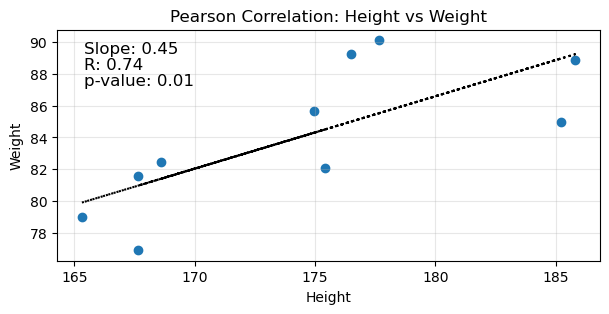

(0.7377062508390316,
 0.014875462783642447,
 0.4538197985997843,
 4.894916823485567)

In [153]:
# Check the Pearson correlation coefficient and p-value
pearson_correlation_plot(height, weight, xlabel='Height', ylabel='Weight', figsize=(7, 3))

### Simple Autocorrelation Function (ACF) Example
- Example on a simulated daily temperature time serieas 

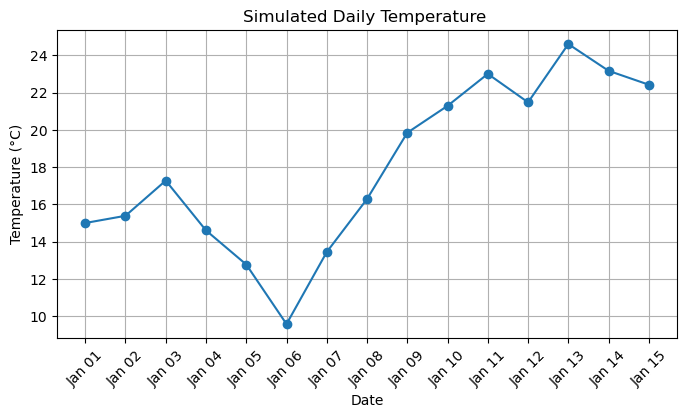

,temperature
date,
2025-01-01,15.000000
2025-01-02,15.386807
2025-01-03,17.273731
2025-01-04,14.603276
2025-01-05,12.773751
2025-01-06,9.579014
2025-01-07,13.443766
2025-01-08,16.285520
2025-01-09,19.842354


In [165]:
# Generate date range
time_steps = 15
dates = pd.date_range(start='2025-01-01', periods= time_steps, freq='D')

# Simulate temperature data with trend and noise
np.random.seed(8)

# creat a random walk process with small trend (0.5) initial value 15 and noise 1.5
base_temp = 15
temperature = np.zeros(time_steps)
temperature[0] = base_temp
for t in range(1, time_steps):
    temperature[t] = temperature[t-1] + 0.25 + np.random.normal(0, 1.5)

# Create DataFrame
temp_df = pd.DataFrame({'temperature': temperature}, index=dates)
temp_df.index.name = 'date'

# Plot the time series of simulated temperature data
plt.figure(figsize=(8, 4))
plt.plot(temp_df.index, temp_df['temperature'], marker='o', linestyle='-', color='tab:blue')
plt.title('Simulated Daily Temperature ')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.xticks(temp_df.index, temp_df.index.strftime('%b %d'))
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Display the Data
temp_df


##### Simple pearson correlation at lag 0

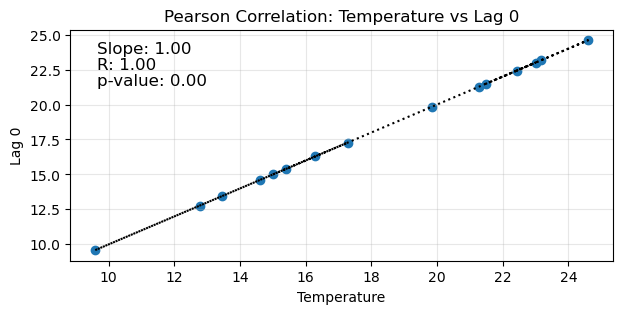

(1.0, 0.0, 0.9999999999999998, 2.0481267748703308e-15)

In [158]:
pearson_correlation_plot(temp_df['temperature'], temp_df['temperature'], 'Temperature', 'Lag 0', figsize=(7, 3))

#### Create lags

In [166]:
# create 3 laged times of the temp_df and insert them as 3 columns in the temp_df
temp_df['lag1'] = temp_df['temperature'].shift(-1)
temp_df['lag2'] = temp_df['temperature'].shift(-2)
temp_df['lag3'] = temp_df['temperature'].shift(-3)

temp_df

,temperature,lag1,lag2,lag3
date,,,,
2025-01-01,15.000000,15.386807,17.273731,14.603276
2025-01-02,15.386807,17.273731,14.603276,12.773751
2025-01-03,17.273731,14.603276,12.773751,9.579014
2025-01-04,14.603276,12.773751,9.579014,13.443766
2025-01-05,12.773751,9.579014,13.443766,16.285520
2025-01-06,9.579014,13.443766,16.285520,19.842354
2025-01-07,13.443766,16.285520,19.842354,21.284596
2025-01-08,16.285520,19.842354,21.284596,22.999227
2025-01-09,19.842354,21.284596,22.999227,21.474087


#### Manual Autocorrelation example

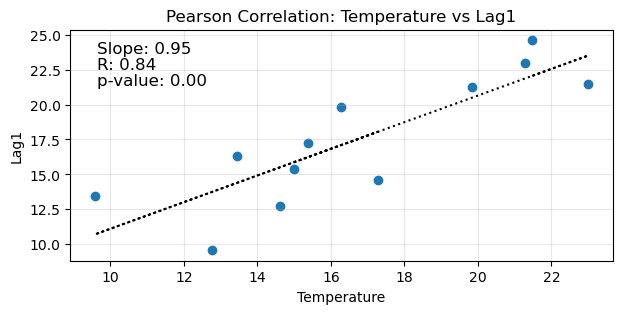

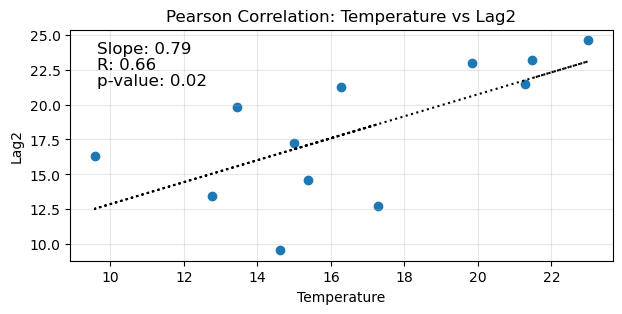

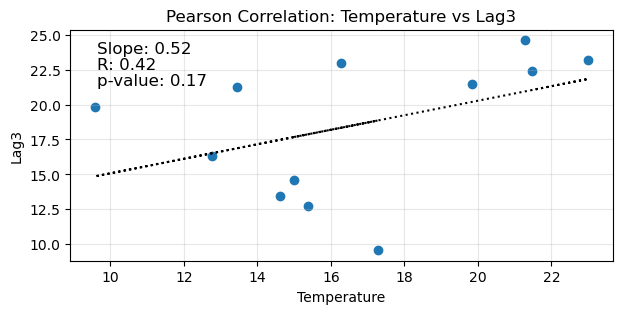

(0.4226670920401341, 0.1710399464369023, 0.5191603540571875, 9.88844580647351)

In [167]:
# Drop rows with NaNs in any of the relevant columns before correlation plots
temp_corr_df = temp_df[['temperature', 'lag1', 'lag2', 'lag3']].dropna()

pearson_correlation_plot(temp_corr_df['temperature'], temp_corr_df['lag1'], 'Temperature', 'Lag1', figsize=(7, 3))
pearson_correlation_plot(temp_corr_df['temperature'], temp_corr_df['lag2'], 'Temperature', 'Lag2', figsize=(7, 3))
pearson_correlation_plot(temp_corr_df['temperature'], temp_corr_df['lag3'], 'Temperature', 'Lag3', figsize=(7, 3))

#### Apply ACF on the simulated temp data

<Figure size 800x200 with 0 Axes>

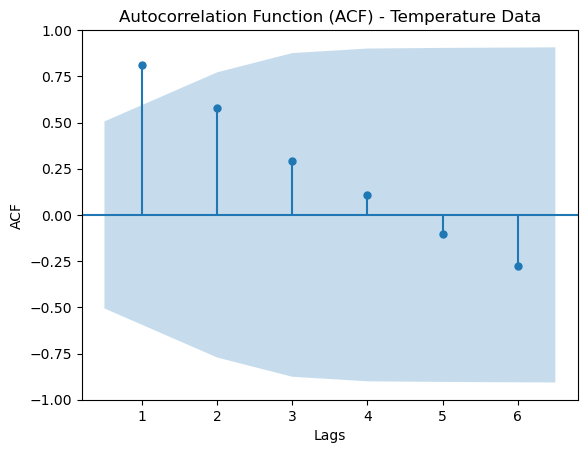

In [168]:
# plot autocorrelation acf plot of temp time series
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(8, 2))
plot_acf(temp_df['temperature'], lags=6, zero=False)
plt.title('Autocorrelation Function (ACF) - Temperature Data')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()


### Explore ACF of Air Passengers 

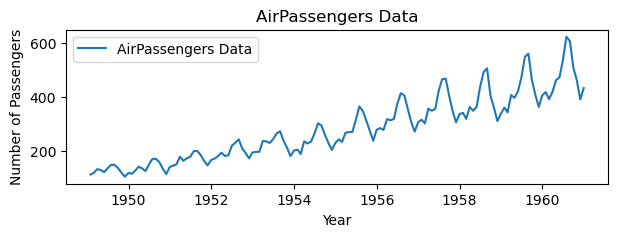

<Figure size 800x200 with 0 Axes>

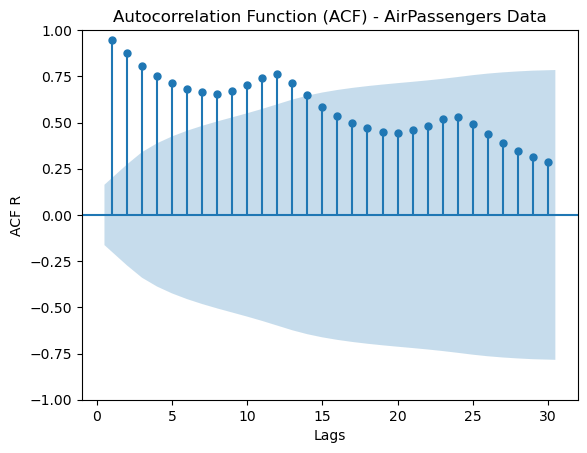

In [181]:
## Autocorrelation Function (ACF) of AirPassengers interpretation
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF of the AirPassengers data
# Plot the original data
plt.figure(figsize=(7, 2))
plt.plot(airp_df.index, airp_df['value'], label='AirPassengers Data')
plt.title('AirPassengers Data')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Plot the ACF of the AirPassengers data
plt.figure(figsize=(8, 2))
plot_acf(airp_df['value'], lags=30, zero=False)
plt.title('Autocorrelation Function (ACF) - AirPassengers Data')
plt.xlabel('Lags')
plt.ylabel('ACF R')
plt.show()


### Explore ACF of BTC prices and transformations

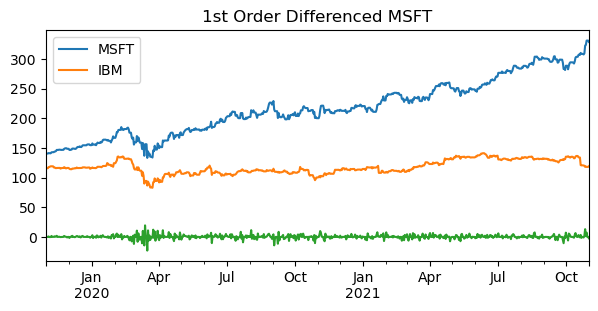

In [175]:
closing_price[['MSFT', 'IBM']].plot(figsize=(7, 3), title='MSFT Stock Price')
msft_diff = closing_price['MSFT'].diff().dropna()
msft_diff.plot(figsize=(7, 3), title='1st Order Differenced MSFT')
plt.show()


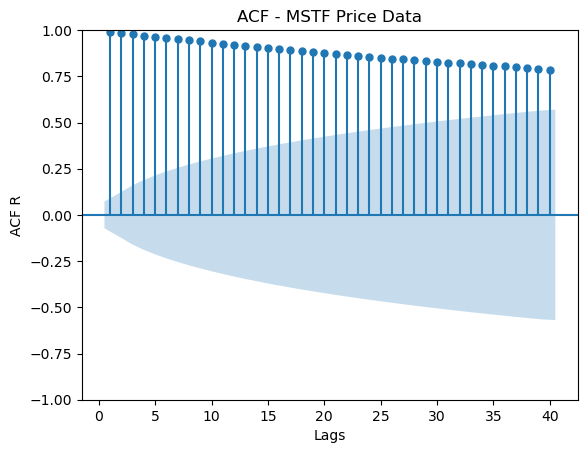

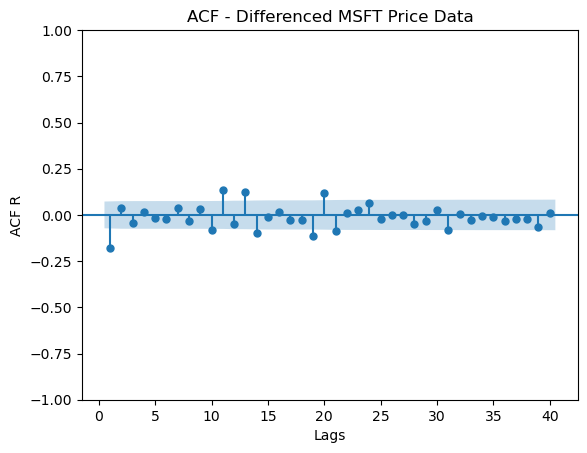

In [182]:
# Plot the ACF of the MSTF stock price
plot_acf(closing_price['MSFT'], lags=40, zero=False)
plt.title('ACF - MSTF Price Data')
plt.xlabel('Lags')
plt.ylabel('ACF R')
plt.show()

# Suggestion: You may also want to plot the ACF of the first-order differenced MSFT data to analyze stationarity.
plot_acf(msft_diff, lags=40, zero=False)
plt.title('ACF - Differenced MSFT Price Data')
plt.xlabel('Lags')
plt.ylabel('ACF R')
plt.show()



## Partial Autocorrelation Function (PACF) 

In [178]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

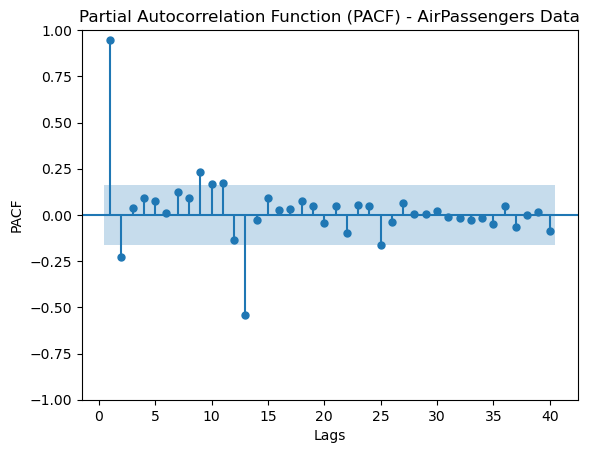

In [179]:
# Plot the PACF of the AirPassengers data
plot_pacf(airp_df['value'], lags=40, method='ywm', zero=False)
plt.title('Partial Autocorrelation Function (PACF) - AirPassengers Data')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()
